In [1]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf1.Session(config=config)

2024-11-28 12:10:55.371048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 12:10:55.487973: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 12:10:55.513500: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 12:10:56.033436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import pandas as pd
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# .npy 파일 경로
x_train_path = '2024_11_28_x_train.npy'
y_train_path = '2024_11_28_y_train.npy'
x_val_path = '2024_11_28_x_val.npy'
y_val_path = '2024_11_28_y_val.npy'

# 데이터 불러오기
x_train = np.load(x_train_path)  # 훈련 이미지 데이터
y_train = np.load(y_train_path)  # 훈련 레이블 데이터
x_val = np.load(x_val_path)      # 검증 이미지 데이터
y_val = np.load(y_val_path)      # 검증 레이블 데이터

# 데이터 확인 (첫 번째 샘플 출력 예시)
print("훈련 이미지 데이터 크기:", x_train.shape)
print("훈련 레이블 데이터 크기:", y_train.shape)
print("검증 이미지 데이터 크기:", x_val.shape)
print("검증 레이블 데이터 크기:", y_val.shape)

훈련 이미지 데이터 크기: (737, 240, 240)
훈련 레이블 데이터 크기: (737, 240, 240, 2)
검증 이미지 데이터 크기: (185, 240, 240)
검증 레이블 데이터 크기: (185, 240, 240, 2)


In [4]:
def plot_accuracy_loss(history):
    """
    훈련 및 검증 정확도와 손실을 시각화합니다.
    
    매개변수:
    - history: 정확도 및 손실 값을 포함하는 훈련 기록 객체.
    """
    plt.figure(figsize=(10, 4))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

def calculate_f1_score(model, x_val, y_val, batch_size=4):
    """
    F1 점수를 계산하고 출력합니다.
    
    매개변수:
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    
    반환값:
    - y_pred: 예측된 레이블.
    - y_true: 실제 레이블.
    """
    y_pred = np.argmax(model.predict(x_val, batch_size=batch_size), axis=-1)
    y_true = np.argmax(y_val, axis=-1)

    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    print(f"F1 점수: {f1:.2f}")

    return y_true, y_pred

def plot_confusion_matrix_with_metrics(y_true, y_pred):
    """
    혼동 행렬을 시각화하고 정밀도, 재현율, F1 점수를 출력합니다.
    
    매개변수:
    - y_true: 실제 레이블.
    - y_pred: 예측된 레이블.
    """
    # Flatten 데이터
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred)
    
    # 메트릭 계산 (zero_division=0 설정)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # 메트릭 출력
    print("=== 성능 지표 ===")
    print(f"정밀도(Precision): {precision:.2f}")
    print(f"재현율(Recall): {recall:.2f}")
    
    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_true_vs_pred_images(model, x_val, y_val, num_images=5, batch_size=4):
    """
    실제 이미지, 라벨 이미지 및 예측된 이미지를 나란히 시각화합니다.
    
    매개변수:
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - num_images: 시각화할 이미지 수 (기본값: 5).
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    """
    # 예측 생성
    y_pred = model.predict(x_val, batch_size=batch_size)
    
    plt.figure(figsize=(25, 3 * num_images))
    for i in range(num_images):
        # 실제 입력 이미지
        plt.subplot(num_images, 5, 5 * i + 1)
        plt.imshow(x_val[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # 실제 라벨 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 2)
        plt.imshow(y_val[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Label Image (Foreground)')
        plt.axis('off')
        
        # 예측된 이미지 (전체 클래스 비교 - argmax로 클래스 라벨 선택)
        plt.subplot(num_images, 5, 5 * i + 3)
        plt.imshow(np.argmax(y_val[i], axis=-1).squeeze(), cmap='gray')
        plt.title('Original Label (Argmax)')
        plt.axis('off')
        
        # 예측된 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 4)
        plt.imshow(y_pred[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Predicted Image (Foreground)')
        plt.axis('off')
        
        # 예측된 이미지 (전체 클래스 비교 - argmax로 클래스 라벨 선택)
        plt.subplot(num_images, 5, 5 * i + 5)
        plt.imshow(np.argmax(y_pred[i], axis=-1).squeeze(), cmap='gray')
        plt.title('Predicted Label (Argmax)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def main_display_result(history, model, x_val, y_val, batch_size=4, num_images=5):
    """
    전체 워크플로우 실행: 정확도/손실 그래프 시각화, F1 점수 계산, 혼동 행렬 및 메트릭 출력, 실제/예측 이미지 비교.
    
    매개변수:
    - history: 정확도 및 손실 값을 포함하는 훈련 기록 객체.
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    - num_images: 시각화할 이미지 수 (기본값: 5).
    """
    # 훈련 및 검증 정확도/손실 그래프 시각화
    plot_accuracy_loss(history)
    
    # F1 점수 계산 및 예측값 반환
    y_true, y_pred = calculate_f1_score(model, x_val, y_val, batch_size=batch_size)
    
    # 혼동 행렬 및 메트릭 출력
    plot_confusion_matrix_with_metrics(y_true, y_pred)
    
    # 실제 이미지와 예측된 이미지 비교 시각화
    plot_true_vs_pred_images(model, x_val, y_val, num_images=num_images, batch_size=batch_size)

In [5]:
# U-Net 모델 정의
def unet_model(input_shape, num_classes=2):
    """
    U-Net 모델 정의 함수.
    
    매개변수:
    - input_shape: 입력 이미지 형태 (높이, 너비, 채널).
    - num_classes: 출력 채널 수. 기본값은 2 (배경과 객체).

    반환값:
    - Keras 모델 객체.
    """
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u4 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u4 = concatenate([u4, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u2 = concatenate([u2, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u1 = concatenate([u1, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # 출력층
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)  # num_classes에 따라 출력 채널 설정

    # 모델 정의
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [18]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Dice 손실 함수 정의
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    total = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3))
    dice_coef = (2.0 * intersection + smooth) / (total + smooth)

    return 1.0 - dice_coef

# Dice 계수 정의
def dice_coef(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

# 복합 손실 함수 정의
def combined_loss(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    bce_loss = K.binary_crossentropy(y_true, y_pred)
    dice_loss_val = 1 - dice_coef(y_true, y_pred)

    return K.mean(bce_loss + dice_loss_val)

def train_unet(train_images, train_labels, val_images, val_labels, input_shape, num_classes=2, batch_size=16, epochs=50):
    """
    U-Net 모델을 학습시키는 함수.

    매개변수:
    - train_images: 훈련 이미지 데이터
    - train_labels: 훈련 라벨 데이터
    - val_images: 검증 이미지 데이터
    - val_labels: 검증 라벨 데이터
    - input_shape: 입력 데이터 형태 (240, 240, 1)
    - num_classes: 출력 클래스 수 (기본값 2)
    - batch_size: 배치 크기 (기본값 16)
    - epochs: 학습 에포크 수 (기본값 50)

    반환값:
    - model: 학습된 U-Net 모델
    - history: 모델 학습 기록
    """
    # 모델 정의
    model = unet_model(input_shape=input_shape, num_classes=num_classes)

    # 모델 컴파일
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=combined_loss,
        metrics=['accuracy', dice_coef]
    )

    # 콜백 설정 (조기 종료를 제거함)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='unet_best_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # 학습
    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

In [19]:
# 입력 데이터 전처리
train_images = x_train[..., tf.newaxis]  # 입력 채널 추가: (737, 240, 240, 1)
val_images = x_val[..., tf.newaxis]      # 검증 데이터 채널 추가: (185, 240, 240, 1)

# 모델 학습 실행
input_shape = (240, 240, 1)  # 입력 크기
num_classes = 2              # 클래스 수
batch_size = 16              # 배치 크기
epochs = 100                 # 학습 에포크 수

# 학습 함수 호출
model, history = train_unet(
    train_images, y_train,
    val_images, y_val,
    input_shape=input_shape,
    num_classes=num_classes,
    batch_size=batch_size,
    epochs=epochs
)

# 모델 저장
model.save('unet_final_model.h5')

# 학습 히스토리 확인
print("Training Completed. History:")
print(history.history)

Epoch 1/100
46/47 [============================>.] - ETA: 0s - loss: 1.1007 - accuracy: 0.7014 - dice_coef: 0.5717
Epoch 1: val_loss improved from inf to 0.99075, saving model to unet_best_model.h5
47/47 [==============================] - 8s 141ms/step - loss: 1.1004 - accuracy: 0.7015 - dice_coef: 0.5743 - val_loss: 0.9908 - val_accuracy: 0.7164 - val_dice_coef: 0.6678
Epoch 2/100
46/47 [============================>.] - ETA: 0s - loss: 0.8247 - accuracy: 0.7107 - dice_coef: 0.7030
Epoch 2: val_loss improved from 0.99075 to 0.73885, saving model to unet_best_model.h5
47/47 [==============================] - 6s 135ms/step - loss: 0.8250 - accuracy: 0.7103 - dice_coef: 0.7011 - val_loss: 0.7389 - val_accuracy: 0.7164 - val_dice_coef: 0.7160
Epoch 3/100
46/47 [============================>.] - ETA: 0s - loss: 0.6345 - accuracy: 0.8080 - dice_coef: 0.7762
Epoch 3: val_loss improved from 0.73885 to 0.51588, saving model to unet_best_model.h5
47/47 [==============================] - 6s 135m

In [13]:
# 모델 저장

model.save('unet_model.h5')  # .h5 파일 형식으로 모델 저장

In [20]:
def plot_accuracy_loss(history):
    """
    훈련 및 검증 정확도와 손실을 시각화합니다.
    """
    plt.figure(figsize=(10, 4))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()


def calculate_f1_score(model, x_val, y_val, batch_size=4):
    """
    F1 점수를 계산하고 출력합니다.
    """
    try:
        # 예측값 생성
        y_pred = model.predict(x_val, batch_size=batch_size)
        y_pred = np.argmax(y_pred, axis=-1)
        y_true = np.argmax(y_val, axis=-1)

        # F1 점수 계산
        f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='weighted')
        print(f"F1 점수: {f1:.2f}")

        return y_true, y_pred
    except Exception as e:
        print(f"F1 점수 계산 중 오류 발생: {e}")
        return None, None


def plot_confusion_matrix_with_metrics(y_true, y_pred):
    """
    혼동 행렬을 시각화하고 정밀도, 재현율, F1 점수를 출력합니다.
    """
    if y_true is None or y_pred is None:
        print("y_true 또는 y_pred가 비어 있습니다.")
        return

    # Flatten 데이터
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred)

    # 메트릭 계산
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # 메트릭 출력
    print("=== 성능 지표 ===")
    print(f"정밀도(Precision): {precision:.2f}")
    print(f"재현율(Recall): {recall:.2f}")
    print(f"F1 점수: {f1:.2f}")

    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()


def plot_true_vs_pred_images(model, x_val, y_val, num_images=5, batch_size=4):
    """
    실제 이미지, 라벨 이미지 및 예측된 이미지를 나란히 시각화합니다.
    """
    # 예측 생성
    y_pred = model.predict(x_val, batch_size=batch_size)

    plt.figure(figsize=(25, 3 * num_images))
    for i in range(num_images):
        # 실제 입력 이미지
        plt.subplot(num_images, 5, 5 * i + 1)
        plt.imshow(x_val[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # 실제 라벨 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 2)
        plt.imshow(y_val[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Label Image (Foreground)')
        plt.axis('off')

        # 예측된 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 3)
        plt.imshow(y_pred[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Predicted Image (Foreground)')
        plt.axis('off')

        # 예측된 이미지 (전체 클래스 비교 - argmax로 클래스 라벨 선택)
        plt.subplot(num_images, 5, 5 * i + 4)
        plt.imshow(np.argmax(y_pred[i], axis=-1).squeeze(), cmap='gray')
        plt.title('Predicted Label (Argmax)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def main_display_result(history, model, x_val, y_val, batch_size=4, num_images=5):
    """
    전체 워크플로우 실행: 정확도/손실 그래프 시각화, F1 점수 계산, 혼동 행렬 및 메트릭 출력, 실제/예측 이미지 비교.
    """
    if history is None or model is None or x_val is None or y_val is None:
        print("입력 매개변수 중 하나 이상이 비어 있습니다.")
        return

    # 훈련 및 검증 정확도/손실 그래프 시각화
    plot_accuracy_loss(history)

    # F1 점수 계산 및 예측값 반환
    y_true, y_pred = calculate_f1_score(model, x_val, y_val, batch_size=batch_size)

    # 혼동 행렬 및 메트릭 출력
    plot_confusion_matrix_with_metrics(y_true, y_pred)

    # 실제 이미지와 예측된 이미지 비교 시각화
    plot_true_vs_pred_images(model, x_val, y_val, num_images=num_images, batch_size=batch_size)


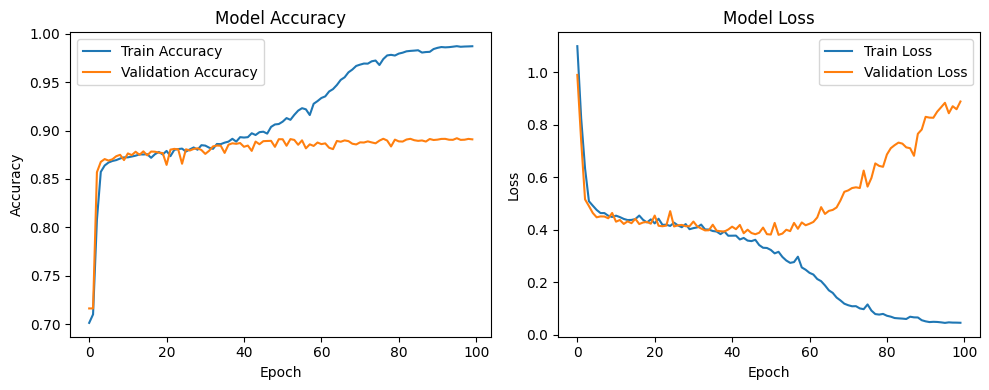

24/24 [==============================] - 1s 18ms/step
F1 점수: 0.89
=== 성능 지표 ===
정밀도(Precision): 0.89
재현율(Recall): 0.89
F1 점수: 0.89


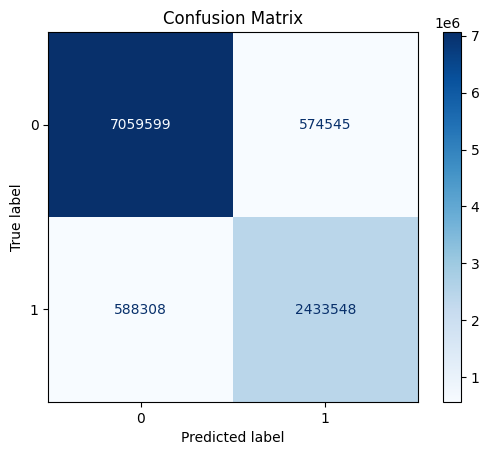

24/24 [==============================] - 0s 18ms/step


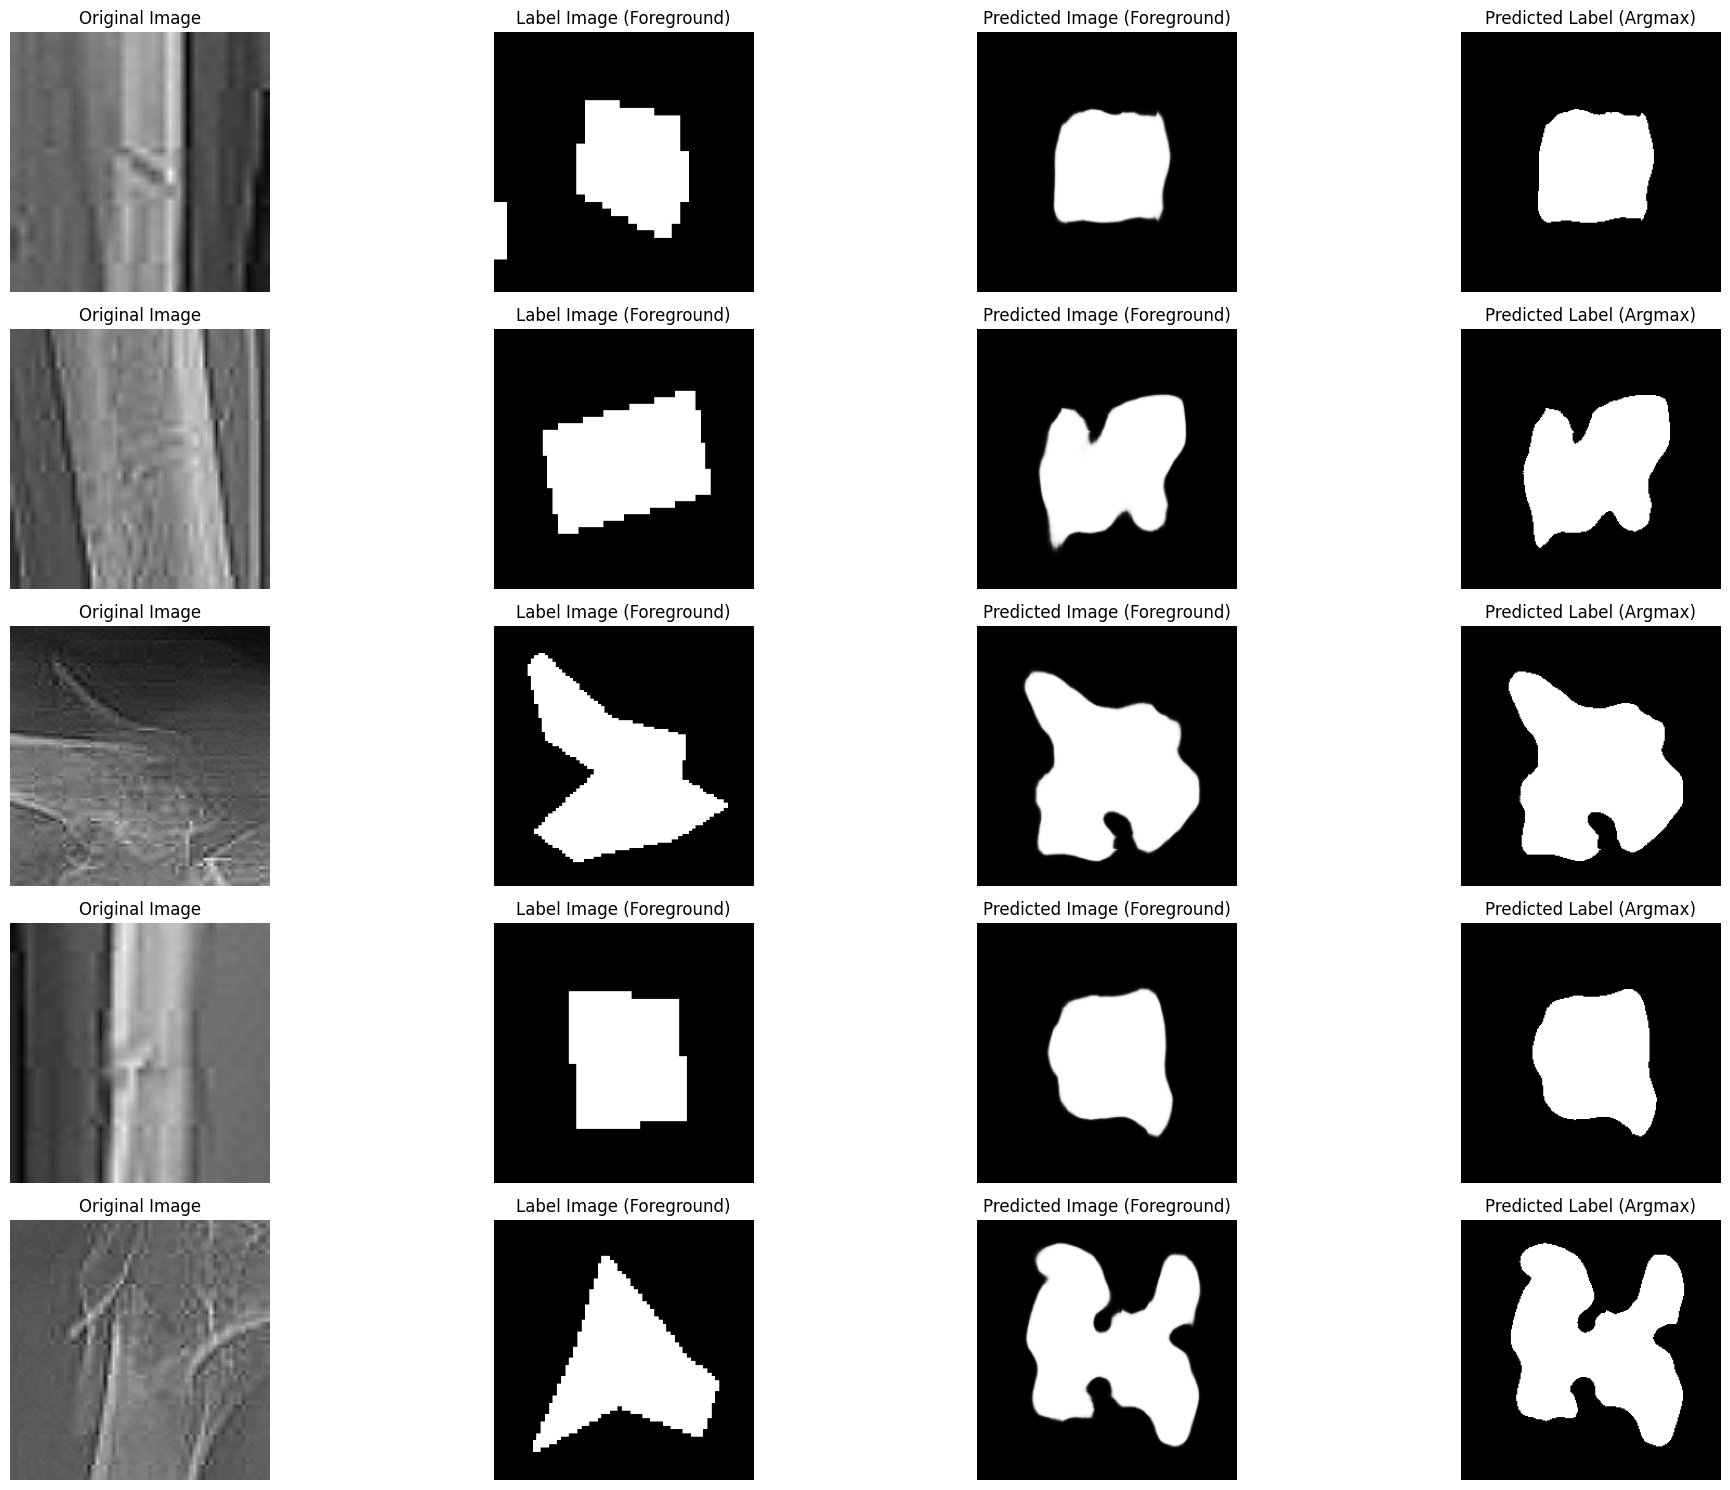

In [21]:
main_display_result(
    history=history,
    model=model,
    x_val=x_val,
    y_val=y_val,
    batch_size=8,
    num_images=5
)